In [1]:
import gurobipy as gp
from gurobipy import GRB
import tomllib as tml
import numpy as np
import display_helper as dh
from copy import deepcopy

Options looks like:
```
options = {
    "WLSACCESSID": "********-****-****-****-************",
    "WLSSECRET": "********-****-****-****-************",
    "LICENSEID": _____,
}
```

In [2]:
# get gurobi credentials
options = tml.load(open("license.toml", "rb"))

In [3]:
# establish env (must close)
env = gp.Env(params=options)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2527858
Academic license 2527858 - for non-commercial use only - registered to mb___@ur.rochester.edu


## Test with MPS File
I made a MPS file by solving LP.mod (written by Quan Luu) with GLPK for Windows.

In [4]:
m = gp.read("model.mps", env=env)
m.reset()
m.optimize()

Read MPS format model from file model.mps
Reading time = 0.01 seconds
LP: 757 rows, 729 columns, 2160 nonzeros
Discarded solution information
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2527858 - for non-commercial use only - registered to mb___@ur.rochester.edu
Optimize a model with 757 rows, 729 columns and 2160 nonzeros
Model fingerprint: 0xcc557f7f
Variable types: 0 continuous, 729 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-03, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective -0.0927000
Presolve removed 27 rows and 0 columns
Presolve time: 0.01s
Presolved: 730 rows, 729 columns, 2160 nonzeros
Variable types: 0 continuous, 729 integer (729 binary)
Foun

I'm not sure this tells us much. Check `glpk_out.txt`, it has the full output of this solution. 
Notable slice:
```
730 rows, 729 columns, 2160 non-zeros
      0: obj =  -4.657500000e-01 inf =   1.000e+01 (2)
      5: obj =  -1.523000000e-01 inf =   0.000e+00 (0)
*   224: obj =   6.790500000e-01 inf =   2.065e-14 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   224: mip =     not found yet <=              +inf        (1; 0)
+   224: >>>>>   6.790500000e-01 <=   6.790500000e-01   0.0% (1; 0)
+   224: mip =   6.790500000e-01 <=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND
Time used:   0.0 secs
Memory used: 1.9 Mb (1980226 bytes)
STATES:
[1 2 3]   [10 11 12]   [19 20 21]
[4 5 6] , [13 14 15] , [22 23 24].
[7 8 9]   [16 17 18]   [25 26 27]

BUCKETS:
Bucket 5: 1 2 3 4 5 6 7 8 9
Bucket 11: 11 12 19 21
Bucket 13: 10 13
Bucket 14: 14 15
Bucket 17: 16 17 18 25 26 27
Bucket 23: 20 22 23 24
```

## Problem Setup
I'm going to try and convert this outright to a Gurobi model.

In [5]:
# establish model (must close)
model = gp.Model(env=env)

In [6]:
# parameters
n = 27
k = 6
V = np.asarray([i for i in range(n)])

prob = np.asarray(
       [0.0137, 0.0298, 0.0137, 
        0.0298, 0.0651, 0.0298, 
        0.0137, 0.0298, 0.0137, 
        0.0298, 0.0651, 0.0298,
        0.0651, 0.1422, 0.0651,
        0.0298, 0.0651, 0.0298,
        0.0137, 0.0298, 0.0137,
        0.0298, 0.0651, 0.0298,
        0.0137, 0.0298, 0.0137]
    )

reward = np.asarray([
    [ 1.0,   0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,   0.5,   0.0, - 0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -1.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -1.5,  -1.0,  -1.5,  -2.0],
    [ 0.5,   1.0,   0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -1.5,  -1.0,  -1.5],
    [ 0.0,   0.5,   1.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -1.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -1.5,  -1.0,  -0.5,  -2.0,  -1.5,  -1.0],
    [ 0.5,   0.0,  -0.5,   1.0,   0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -1.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -1.5],
    [ 0.0,   0.5,   0.0,   0.5,   1.0,   0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0],
    [-0.5,   0.0,   0.5,   0.0,   0.5,   1.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -1.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -1.5,  -1.0,  -0.5],
    [ 0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5,   1.0,   0.5,   0.0,  -0.5,  -1.0,  -1.5,   0.0,  -0.5,  -1.0,  0.5,    0.0,  -0.5,  -1.0,  -1.5,  -2.0,  -0.5,  -1.0,  -1.5,   0.0,  -0.5,  -1.0],
    [-0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,   0.5,   1.0,   0.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,  -1.5,  -1.0,  -1.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5],
    [-1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,   0.5,   1.0,  -1.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,  -2.0,  -1.5,  -1.0,  -1.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0],
    [ 0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -1.5,   1.0,   0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -1.5],
    [ 0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,   0.5,   1.0,   0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0],
    [-0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -1.5,  -1.0,  -0.5,   0.0,   0.5,   1.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -1.5,  -1.0,  -0.5],
    [ 0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5,   1.0,   0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0],
    [-0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,   0.5,   1.0,   0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5],
    [-1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,   0.5,   1.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0],
    [-0.5,  -1.0,  -1.5,   0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5,   1.0,   0.5,   0.0,  -0.5,  -1.0,  -1.5,   0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5],
    [-1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,   0.5,   1.0,   0.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0],
    [-1.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,   0.5,   1.0,  -1.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5],
    [ 0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -1.5,  -1.0,  -1.5,  -2.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -1.5,   1.0,   0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0],
    [-0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -1.5,  -1.0,  -1.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,   0.5,   1.0,   0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5],
    [-1.0,  -0.5,   0.0,  -1.5,  -1.0,  -0.5,  -2.0,  -1.5,  -1.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -1.5,  -1.0,  -0.5,   0.0,   0.5,   1.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0],
    [-0.5,  -1.0,  -1.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -1.5,   0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5,   1.0,   0.5,   0.0,   0.5,   0.0,  -0.5],
    [-1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,   0.5,   1.0,   0.5,   0.0,   0.5,   0.0],
    [-1.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -1.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,   0.5,   1.0,  -0.5,   0.0,   0.5],
    [-1.0,  -1.5,  -2.0,  -0.5,  -1.0,  -1.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -1.5,   0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,  -1.0,   0.5,   0.0,  -0.5,   1.0,   0.5,   0.0],
    [-1.5,  -1.0,  -1.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,   0.5,   1.0,   0.5],
    [-2.0,  -1.5,  -1.0,  -1.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -1.5,  -1.0,  -0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,  -1.0,  -0.5,   0.0,  -0.5,   0.0,   0.5,   0.0,   0.5,   1.0],
])

In [7]:
# Create Hess Variables
# GPL: var x{V, V} >= 0, <= 1, binary;
x = model.addVars(V, V, ub=1, vtype=GRB.BINARY)

In [8]:
# state objective
# GPL: maximize EP: sum{i in V} PROB[i] * sum{j in V} x[i, j] * REWARD[i, j];
# gp.quicksum( prob[i] * x[i][j] * reward[i][j] for i in V for j in V )
objective = gp.quicksum( gp.quicksum( (prob[i] * x[i,j] * reward[i][j]) for j in V) for i in V )
model.setObjective(objective, GRB.MAXIMIZE)

In [9]:
# add constraints

# /* there are exactly k buckets */
# kBucketConstr: sum{j in V} x[j, j] = k;
k_bucket = gp.quicksum( (x[j,j]) for j in V ) == k
model.addConstr(k_bucket)

# /* a state can only belong to one bucket */
# uniqueBucketConstr{i in V}: sum{j in V} x[i, j] = 1;
unique_bucket = (gp.quicksum( (x[i,j]) for j in V ) == 1 for i in V)
model.addConstrs(unique_bucket)

# /* a state cannot belong to a non-existant bucket */
# nonexBucketConstr{i in V, j in V}: x[i, j] <= x[j, j];
nonex_bucket = ( (x[i,j] <= x[j,j]) for i in V for j in V )
model.addConstrs(nonex_bucket)

model.update()

In [10]:
# can we solve?
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2527858 - for non-commercial use only - registered to mb___@ur.rochester.edu
Optimize a model with 757 rows, 729 columns and 2160 nonzeros
Model fingerprint: 0xbd42aa8b
Variable types: 0 continuous, 729 integer (729 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-03, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective -0.0927000
Presolve removed 27 rows and 0 columns
Presolve time: 0.01s
Presolved: 730 rows, 729 columns, 2160 nonzeros
Variable types: 0 continuous, 729 integer (729 binary)
Found heuristic solution: objective 0.3946500

Root relaxation: objective 6.790500e-01, 88 iterations, 0.00 seconds (0.00 work units)

    Nodes

### Solution Extraction
This was a little easier than I thought, thanks to Quan's code.

Bucket 5: 1 2 3 5 7 9 
Bucket 13: 4 10 13 25 
Bucket 14: 11 14 
Bucket 15: 6 12 15 27 
Bucket 17: 8 16 17 18 26 
Bucket 23: 19 20 21 22 23 24 


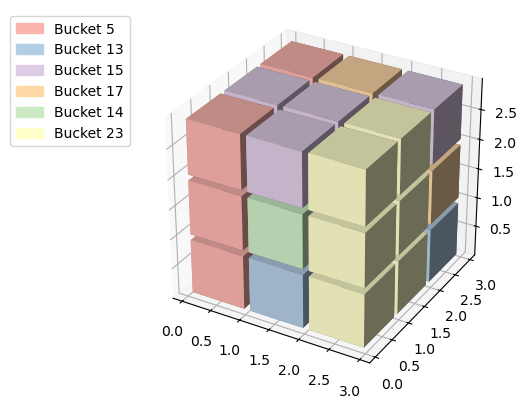

In [11]:
centers = [j for j in V if x[j,j].getAttr("x") == 1]
bucket_lookup = dict()

for ind, j in enumerate(centers):
    print(f"Bucket {j+1}: ", end="")
    members = [i for i in V if x[i,j].getAttr("x") == 1]
    for i in members:
        print(f"{i+1} ", end="")
        bucket_lookup[i] = ind
    print()

og_cube, legend = dh.cube_from_lookup(bucket_lookup, 3, centers)
dh.show(og_cube, legend)

cube = deepcopy(og_cube)

```
STATES:
[1 2 3]   [10 11 12]   [19 20 21]
[4 5 6] , [13 14 15] , [22 23 24].
[7 8 9]   [16 17 18]   [25 26 27]

BUCKETS:
Bucket 5: 1 2 3 4 5 6 7 8 9
Bucket 11: 11 12 19 21
Bucket 13: 10 13
Bucket 14: 14 15
Bucket 17: 16 17 18 25 26 27
Bucket 23: 20 22 23 24
```

GLPK Output again for comparison.

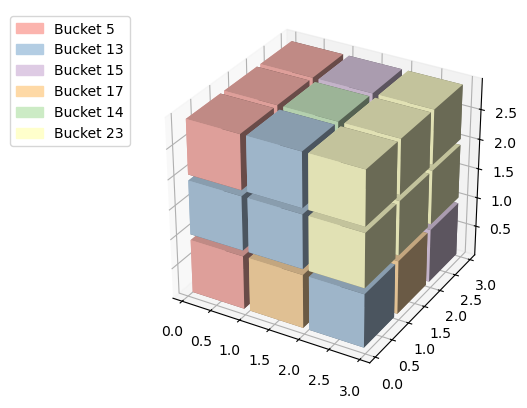

In [12]:
# we can rotate the cube and redisplay
cube = dh.rotate_aboutX(cube)
dh.show(cube, legend)

In [13]:
# sub-optimals?
n_solutions = model.getAttr("SolCount")

for n in range(1, n_solutions):
    model.params.SolutionNumber = n
    print(f"Sub-optimal solution {n}")
    centers = [j for j in V if x[j,j].getAttr("Xn") == 1]
    for j in centers:
        print(f"Bucket {j+1}: ", end="")
        members = [i for i in V if x[i,j].getAttr("Xn") == 1]
        for i in members:
            print(f"{i+1} ", end="")
        print()
    print()

Sub-optimal solution 1
Bucket 8: 1 2 5 8 14 19 
Bucket 9: 6 9 18 
Bucket 12: 3 11 12 15 20 21 
Bucket 16: 4 7 10 13 16 17 25 
Bucket 24: 22 23 24 
Bucket 26: 26 27 

Sub-optimal solution 2
Bucket 8: 1 8 14 
Bucket 9: 6 9 11 19 25 
Bucket 12: 12 13 
Bucket 16: 4 7 10 15 16 17 20 23 
Bucket 24: 3 5 18 22 24 
Bucket 26: 2 21 26 27 



In [14]:
# closing these objects for best practice

model.close()
m.close()
env.close()